# Main Problem

Classify whether an individual survives the Titanic Ship Catastrophe based on individual and trip characteristics.

The final model should be able to take passenger information and predict whether the passenger would survive on the Titanic.

In [42]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pandas_profiling
from sklearn import (
                    ensemble,
                    preprocessing,
                    tree,
                    impute
                    )
from sklearn.metrics import (
                    auc,
                    confusion_matrix,
                    roc_auc_score,
                    roc_curve,
                    precision_score
                            )
from sklearn.model_selection import (
                    train_test_split,
                    StratifiedKFold
                                    )

from yellowbrick.classifier import (
                    ConfusionMatrix,
                    ROCAUC
                                    )
from yellowbrick.model_selection import (
                    LearningCurve,
                                        )
from sklearn.experimental import enable_iterative_imputer

from sklearn.dummy import DummyClassifier

from sklearn.linear_model import (
        LogisticRegression
                                )

from sklearn.tree import DecisionTreeClassifier

from sklearn.neighbors import KNeighborsClassifier

from sklearn.naive_bayes import GaussianNB

from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier

from mlxtend.classifier import StackingClassifier

import xgboost

## Gather the Data

Columns in the dataset
- pclass - Passenger class (1 = 1st, 2 = 2nd, 3 = 3rd)
- survival - Survival (0=No, 1=Yes)
- name - Name
- sex - Sex
- age - Age
- sibsp - Number of siblings/spouses aboard
- parch - Number of parents/children aboard
- ticket - Ticket number
- fare - Passenger fare
- cabin - Cabin
- embarked - Point of embarkation (C = Cherbourg, Q = Queenstown,
S = Southampton)
- boat - Lifeboat
- body Body identification Number
- home.dest - Home/Destination

In [2]:
# URL to the dataset
url = r"data/titanic.csv"

# Read the dataset
titanic_df = pd.read_csv(url)

# Keep a copy of the original dataset
orig_df = titanic_df.copy(deep=True)

# Preview the data
titanic_df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


## Cleaning the Data

Cleaning the data can take a bit of time. It helps to have access to a subject
matter expert (SME) who can provide guidance on dealing with outliers or
missing data.

In [3]:
titanic_df.dtypes

pclass         int64
survived       int64
name          object
sex           object
age          float64
sibsp          int64
parch          int64
ticket        object
fare         float64
cabin         object
embarked      object
boat          object
body         float64
home.dest     object
dtype: object

In [4]:
# Using Pandas Profiling to look into the dataset


# View a report of the data
pandas_profiling.ProfileReport(titanic_df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
# Get the shape of the data

titanic_df.shape

(1309, 14)

In [6]:
# Note that the count statistic does not include NaN values
titanic_df.iloc[:, :].describe()

,pclass,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,0.381971,29.881135,0.498854,0.385027,33.295479,160.809917
std,0.837836,0.486055,14.413500,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


In [7]:
# Where are the nulls

titanic_df.isnull().sum()

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

In [8]:
# Checking for embarked value

titanic_df.embarked.value_counts(dropna=False)

S      914
C      270
Q      123
NaN      2
Name: embarked, dtype: int64

In [9]:
# Dropping leaky columns

titanic_df = (
            titanic_df.drop(
                            columns=['body',
                                     'cabin',
                                     'boat',
                                     'home.dest',
                                     'name',
                                     'ticket']  
                            )
             )

In [10]:
# Convert the embarked column to categorical data

titanic_df['embarked'] = (
                            titanic_df['embarked']
                            # Convert to categorical type
                            .astype('category')
                         )




> The above code assumes that the 2 missing values in embarked will be `embarked_C` variables.

In [11]:
# Convert the sex column to category

titanic_df['sex'] = (
                        titanic_df['sex']
                        # Set as category
                        .astype('category')
)

In [12]:
titanic_df.dtypes

pclass         int64
survived       int64
sex         category
age          float64
sibsp          int64
parch          int64
fare         float64
embarked    category
dtype: object

In [13]:
# Now, convert all categorical variables to columns

# Now lets create dummy columns for the categorical data and avoid Perfoect Colinearity
titanic_df = pd.get_dummies(titanic_df, columns=['embarked', 'sex'], drop_first=True)

titanic_df.head()

,pclass,survived,age,sibsp,parch,fare,embarked_Q,embarked_S,sex_male
0,1,1,29.0000,0,0,211.3375,0,1,0
1,1,1,0.9167,1,2,151.5500,0,1,1
2,1,0,2.0000,1,2,151.5500,0,1,0
3,1,0,30.0000,1,2,151.5500,0,1,1
4,1,0,25.0000,1,2,151.5500,0,1,0


In [14]:
titanic_df.isnull().sum()

pclass          0
survived        0
age           263
sibsp           0
parch           0
fare            1
embarked_Q      0
embarked_S      0
sex_male        0
dtype: int64

In [15]:
from sklearn import model_selection

y = titanic_df['survived']

X = titanic_df.drop(columns='survived')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [16]:
# View the missing values of X_train before imputation

X_train.isnull().sum()

pclass          0
age           187
sibsp           0
parch           0
fare            1
embarked_Q      0
embarked_S      0
sex_male        0
dtype: int64

In [17]:
num_cols = [
            'pclass',
            'age',
            'sibsp',
            'parch',
            'fare'
        ]

cat_cols = [
            'embarked_Q',
            'embarked_S',
            'sex_male'
            ]

feature_cols = num_cols + cat_cols

# Impute the missing values based on characteristics of the numeric columns
imputer = impute.IterativeImputer()

imputed = imputer.fit_transform(X_train[feature_cols])

X_train.loc[:, feature_cols] = imputed

X_train.isnull().sum()

pclass        0
age           0
sibsp         0
parch         0
fare          0
embarked_Q    0
embarked_S    0
sex_male      0
dtype: int64

In [18]:
# X_test before imputation

X_test.isnull().sum()

pclass         0
age           76
sibsp          0
parch          0
fare           0
embarked_Q     0
embarked_S     0
sex_male       0
dtype: int64

In [19]:
# Now using the imputer from the training set

imputed = imputer.transform(X_test[feature_cols])

X_test.loc[:, feature_cols] = imputed

X_test.isnull().sum()

pclass        0
age           0
sibsp         0
parch         0
fare          0
embarked_Q    0
embarked_S    0
sex_male      0
dtype: int64

In [20]:
# Standardizing Columns

scaler = preprocessing.StandardScaler()

# Standardize the Numeric Features leaving out the Categorical features
X_train.loc[:, num_cols] = scaler.fit_transform(X_train[num_cols])


# Standardising the test data
X_test.loc[:, num_cols] = scaler.transform(X_test[num_cols])

## Code Refactoring

Two function will be used to perform all operations.
- One to perform General Data Cleaning Tasks
- The other to split the data into training and tests sets

In [21]:
def clean_titanic(titanic_df: pd.DataFrame):
    """
        Perform cleaning on the Titanic dataset
    """    
    # Create a new copy of the Dataset without altering the orginal df 
    df = titanic_df.copy(deep=True)    
    # Drop irrelevant columns
    df = (
            df.drop(
                    columns=['body',
                             'cabin',
                             'boat',
                             'home.dest',
                             'name',
                             'ticket']  
                    )
             )
    
    # Convert the embarked column to categorical data
    df['embarked'] = (
                      df['embarked']
                      # Convert to categorical type
                      .astype('category')
                     )
    # Convert the sex column to categorical data
    df['sex'] = (
                df['sex']
                # Set as category
                .astype('category')
                )
    # Now lets create dummy columns for the categorical data and avoid Perfoect Colinearity
    df = pd.get_dummies(df, columns=['embarked', 'sex'], drop_first=True) 
    
    return df




In [22]:
def get_train_test_X_y(clean_titanic_df: pd.DataFrame, y_col: str, size: float = 0.3):
    # Get a copy of the original df
    df = clean_titanic_df.copy(deep=True)
    # Get the target
    y = df[y_col]
    # Get the features
    X = df.drop(columns=y_col)
    # Split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, random_state=42)
    # Get all feature cols
    feature_cols = X.columns
    # Get all Numeric columns
    num_cols = [
            'pclass',
            'age',
            'sibsp',
            'parch',
            'fare'
        ]

    cat_cols = [
                'embarked_Q',
                'embarked_S',
                'sex_male'
                ]

    # Impute the missing values based on characteristics of the numeric columns
    imputer = impute.IterativeImputer()

    X_train.loc[:, feature_cols] = imputer.fit_transform(X_train[feature_cols])

    X_test.loc[:, feature_cols] = imputer.transform(X_test[feature_cols])
    
    # Standardising the numeric columns
    scaler = preprocessing.StandardScaler()

    # Standardize the Numeric Features leaving out the Categorical features
    X_train.loc[:, num_cols] = scaler.fit_transform(X_train[num_cols])


    # Standardising the test data
    X_test.loc[:, num_cols] = scaler.transform(X_test[num_cols])
    
    return X_train, X_test, y_train, y_test
    

In [23]:
#Cleaning Data
clean_df = clean_titanic(titanic_df=orig_df)


# Get the testing and training set
X_train, X_test, y_train, y_test = get_train_test_X_y(clean_titanic_df=clean_df, y_col='survived')

In [24]:
X_test.head()

,pclass,age,sibsp,parch,fare,embarked_Q,embarked_S,sex_male
1148,0.825248,0.490222,-0.498616,-0.432553,-0.502660,0.0,1.0,1.0
1049,0.825248,-0.679582,0.425943,0.686709,-0.339464,0.0,0.0,1.0
982,0.825248,-0.137515,-0.498616,-0.432553,-0.488062,0.0,1.0,1.0
808,0.825248,-0.137577,-0.498616,-0.432553,-0.485141,0.0,1.0,1.0
1195,0.825248,0.020340,-0.498616,-0.432553,-0.490823,1.0,0.0,1.0


## Baseline Model



In [25]:
# Building a dummy classifier

bm = DummyClassifier()

# Fit to the training data
bm.fit(X_train, y_train)

# Get the Precision Score
precision_score(y_test, bm.predict(X_test))

# You could also use the score below but his is sometime misleading
# bm.score(X_test, y_test)      

c:\Users\INNO\Documents\Python Development\ML-Pocket-Reference\.ml_pocket_ref\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0

## Various Families

When using cross-validation, feed all the X's and y's. There is no need to have a separate testing and training data set.

In [26]:
# Concatenate all the data
X = pd.concat([X_train, X_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)



In [27]:
# Running various models

models = [DummyClassifier, LogisticRegression, DecisionTreeClassifier, KNeighborsClassifier, 
          GaussianNB, SVC, RandomForestClassifier, xgboost.XGBClassifier]

for model in models:
    cls = model()
    k_fold = model_selection.KFold(
                    n_splits = 10
                                 )
    s = model_selection.cross_val_score(
            cls, X, y, scoring="roc_auc",cv=k_fold    
                                       )
    # You want models with a High AUC an
    print(
        f'{model.__name__:22} AUC:'
        f'{s.mean():3f} STD: {s.std():.2f}'
        )

DummyClassifier        AUC:0.500000 STD: 0.00
LogisticRegression     AUC:0.843107 STD: 0.03
DecisionTreeClassifier AUC:0.760577 STD: 0.04
KNeighborsClassifier   AUC:0.829862 STD: 0.05
GaussianNB             AUC:0.817765 STD: 0.04
SVC                    AUC:0.836291 STD: 0.05
RandomForestClassifier AUC:0.847965 STD: 0.04
XGBClassifier          AUC:0.859710 STD: 0.03


> An algorithm that has a slightly smaller average score but tighter standard deviation might be a
better choice.

## Stacking

For maximum performance at the cost of interpretability, `stacking` is an option.

In [28]:
# Stacking Classifiers

clfs = [ model() for model in models ]

stack = StackingClassifier(
                            classifiers=clfs,
                            meta_classifier=LogisticRegression()
)

# Performing Cross-Validation
k_fold = model_selection.KFold(n_splits=10)


# Lets get the score
score = model_selection.cross_val_score(stack, X,y, scoring='roc_auc', cv=k_fold)


# Lets get the results
print(
        f'{stack.__class__.__name__:22} AUC:'
        f'{score.mean():3f} STD: {score.std():.2f}'
        )

StackingClassifier     AUC:0.782973 STD: 0.05


> The stacking classifier does not do as well in this case.

## A Random Forest Model



In [29]:
# Initialize the RF Model
rf = ensemble.RandomForestClassifier(n_estimators=100, random_state=42)

# Train Model
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### Evaluate a Random Forest Model

In [30]:
# Lets look at the score
rf.score(X_test, y_test)

0.8015267175572519

In [31]:
# A look at precision score
precision_score(y_test, rf.predict(X_test))

0.8013245033112583

A nice benefit of tree-based models is that you can inspect the feature
importance. The feature importance tells you how much a feature contributes
to the model.

### Optimize the Model

Models have `hyperparameters` that control how they behave. By varying the values for these parameters, we change their performance. Sklearn has a grid search class to evaluate a model with different combinations of parameters and return the best result.

In [32]:
rf_4 = ensemble.RandomForestClassifier()

params = {
    'max_features': [0.4, 'auto', 'sqrt', 'log2'],
    'n_estimators': [100, 200, 300, 400],
    'min_samples_leaf': [1, 2, 4, 8],
    'random_state': [42]
}



cv = model_selection.GridSearchCV(rf_4, params, n_jobs=-1).fit(X_train, y_train)


# Get the best parameters
print(cv.best_params_)

{'max_features': 0.4, 'min_samples_leaf': 4, 'n_estimators': 400, 'random_state': 42}


In [33]:
# Initialize the RF model with the best params
rf5 = ensemble.RandomForestClassifier(**cv.best_params_)

# Fit the optimized model to the training set
rf5.fit(X_train, y_train)

# Lets get the score
rf5.score(X_test, y_test)

0.7964376590330788

## Confusion Matrix


A confusion matrix allows us to see the correct classifications as well as
false positives and false negatives. It may be that we want to optimize
toward false positives or false negatives, and different models or parameters
can alter that.

In [34]:
# Get the Prediction
y_pred = rf5.predict(X_test)


# Construct a Confusion Matrix
confusion_matrix(y_test, y_pred)

array([[207,  17],
       [ 63, 106]], dtype=int64)

c:\Users\INNO\Documents\Python Development\ML-Pocket-Reference\.ml_pocket_ref\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


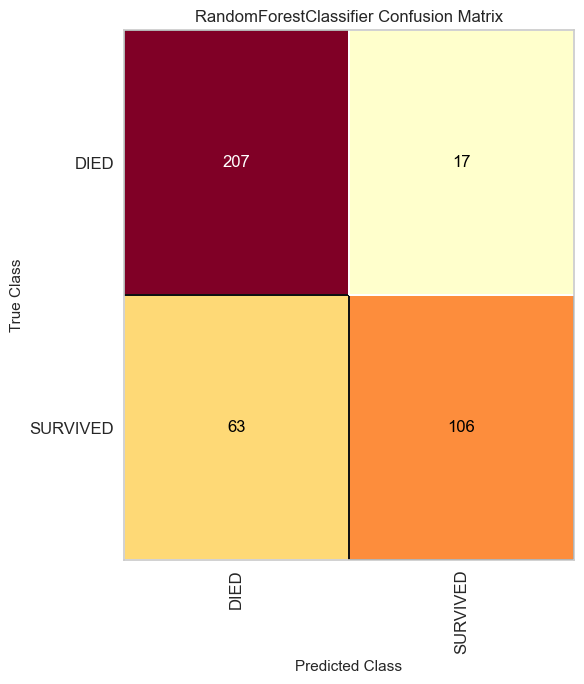

<AxesSubplot:title={'center':'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [35]:
# Create a viz of the Confusion Matrix

mapping = {0: 'DIED', 1: 'SURVIVED'}

fig, ax = plt.subplots(figsize=(6, 7))

cm_viz = ConfusionMatrix(
                            rf5,
                            classes=['DIED', 'SURVIVED'],
                            label_encoder=mapping
    )


cm_viz.score(X_test, y_test)

cm_viz.poof()

## ROC Curve

This is used to operate classifiers is used to evaluate classifiers. By measuring the area under the curve (AUC), different classifiers can be compared.

In [36]:
# Metric for the ROC
y_pred = rf5.predict(X_test)

roc_auc_score(y_test, y_pred)

0.7756630388841927

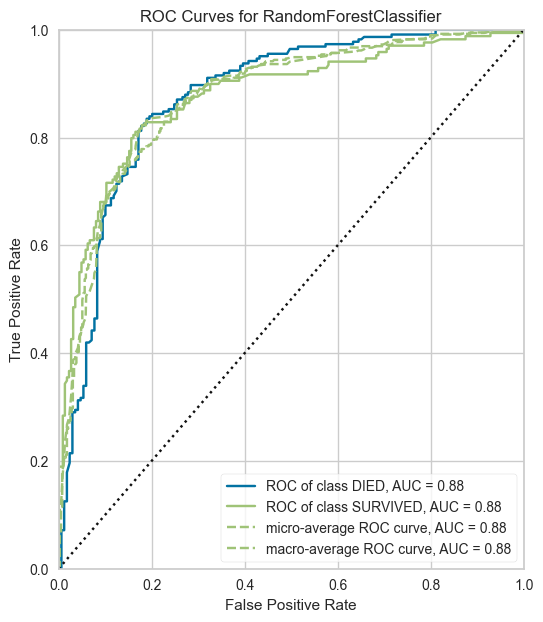

<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [40]:
# Visualizing the ROC Curve

fig, ax = plt.subplots(figsize=(6, 7))


# Initialize the RF model with the best params
rf5 = ensemble.RandomForestClassifier(**cv.best_params_)


# Instantiate the visualizer with the rf classifier
roc_viz = ROCAUC(rf5, classes=['DIED', 'SURVIVED'])


# Fit the training data to the visualizer
roc_viz.fit(X_train, y_train)

# Evaluate the model on the test data
roc_viz.score(X_test, y_test)

roc_viz.show()


## Learning Curve

A learning curve is used to tell us if the training data is enough. It trains the model with increasing portions of the data and measures the score. If the cross-validation score continues to climb, then we might need to invest in gathering more data.

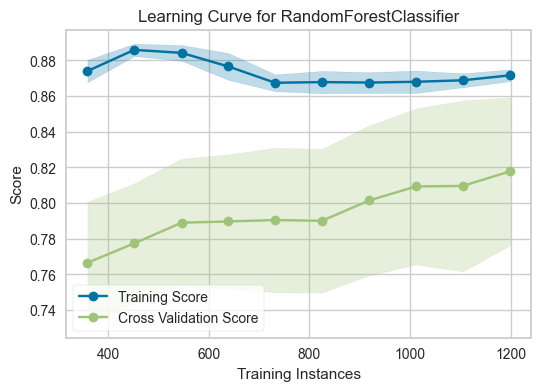

<AxesSubplot:title={'center':'Learning Curve for RandomForestClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [43]:
fig, ax = plt.subplots(figsize=(6,4))


cv = StratifiedKFold(12)


sizes = np.linspace(0.3, 1.0, 10)

lc_viz = LearningCurve(
                    rf5,
                    cv=cv, 
                    train_sizes=sizes,
                    scoring='f1_weighted',
                    n_jobs=4,
                    ax=ax
                    )

lc_viz.fit(X,y)

lc_viz.poof()

> This learning curve shows that as we add more training samples, our cross-validation
(testing) scores appear to improve.